# 1 Multinomial Logistic Regression

In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
import wandb
import math

## 1.1 Dataset Analysis and Preprocessing

#### 1. Describe the dataset using mean, standard deviation, min, and max values for all attributes.


In [22]:
df = pd.read_csv('WineQT.csv')
df.describe()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,Id
count,1143.000000,1143.000000,1143.000000,1143.000000,1143.000000,1143.000000,1143.000000,1143.000000,1143.000000,1143.000000,1143.000000,1143.000000,1143.000000
mean,8.311111,0.531339,0.268364,2.532152,0.086933,15.615486,45.914698,0.996730,3.311015,0.657708,10.442111,5.657043,804.969379
std,1.747595,0.179633,0.196686,1.355917,0.047267,10.250486,32.782130,0.001925,0.156664,0.170399,1.082196,0.805824,463.997116
min,4.600000,0.120000,0.000000,0.900000,0.012000,1.000000,6.000000,0.990070,2.740000,0.330000,8.400000,3.000000,0.000000
25%,7.100000,0.392500,0.090000,1.900000,0.070000,7.000000,21.000000,0.995570,3.205000,0.550000,9.500000,5.000000,411.000000
50%,7.900000,0.520000,0.250000,2.200000,0.079000,13.000000,37.000000,0.996680,3.310000,0.620000,10.200000,6.000000,794.000000
75%,9.100000,0.640000,0.420000,2.600000,0.090000,21.000000,61.000000,0.997845,3.400000,0.730000,11.100000,6.000000,1209.500000
max,15.900000,1.580000,1.000000,15.500000,0.611000,68.000000,289.000000,1.003690,4.010000,2.000000,14.900000,8.000000,1597.000000


Handling for the missing or inconsistent data values is not required.

#### 2. Draw a graph that shows the distribution of the various labels across the entire dataset.

In [23]:
n = (df['Id'].unique().shape[0])
X_plot = list(range(1, n + 1))

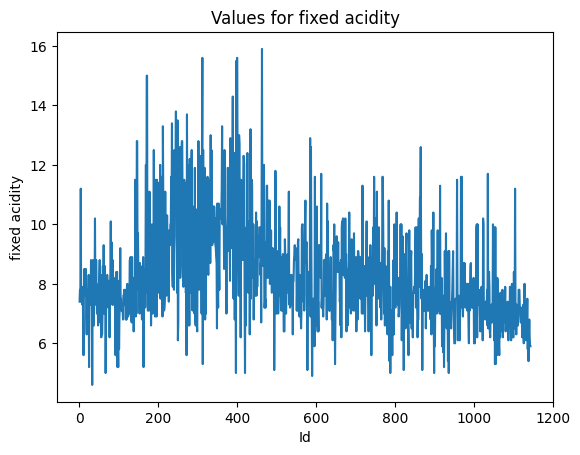

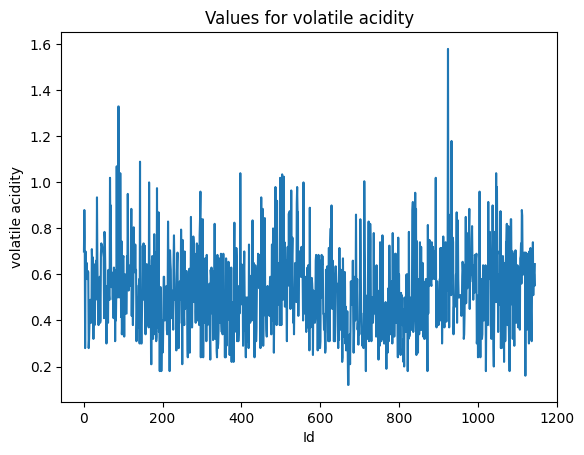

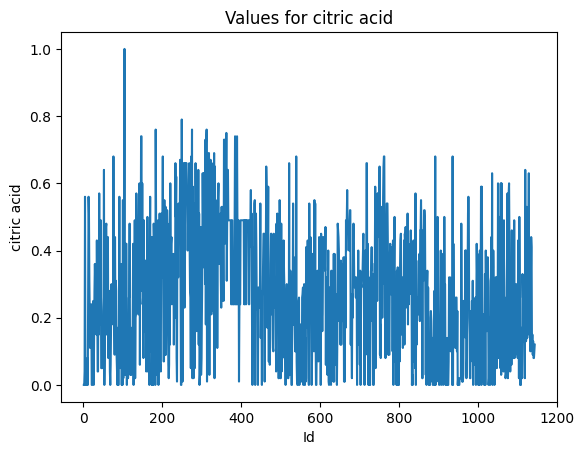

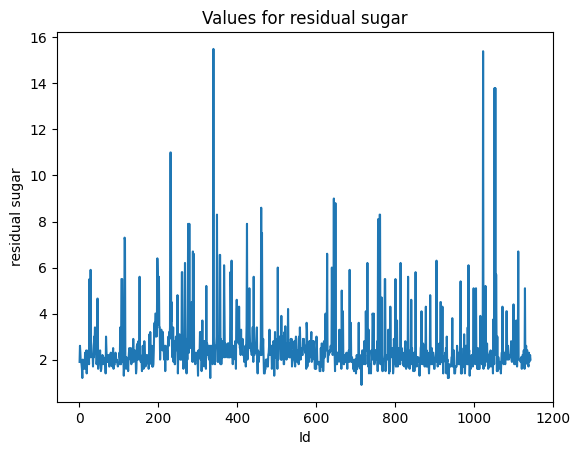

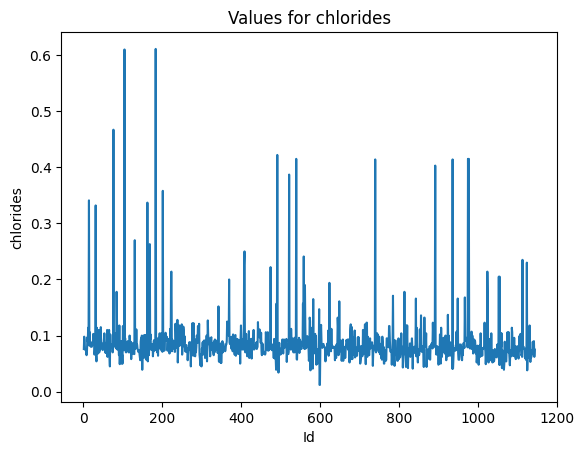

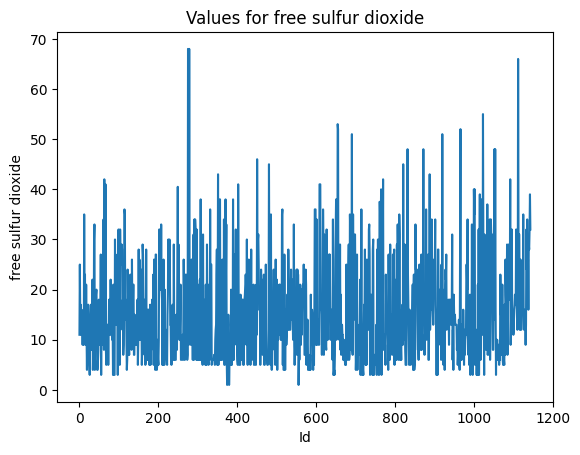

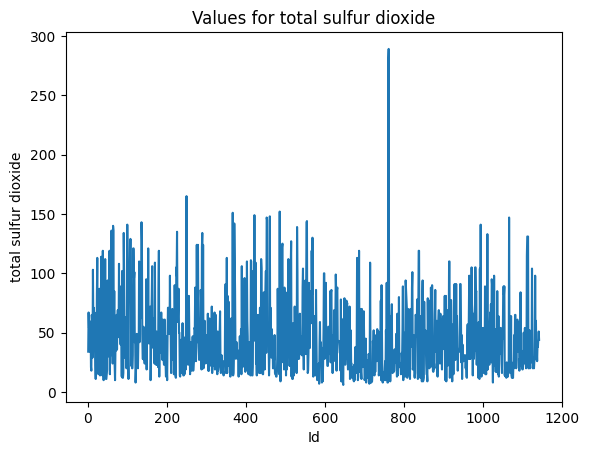

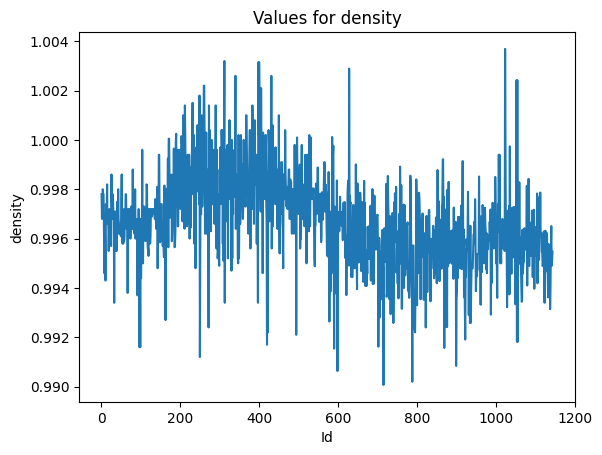

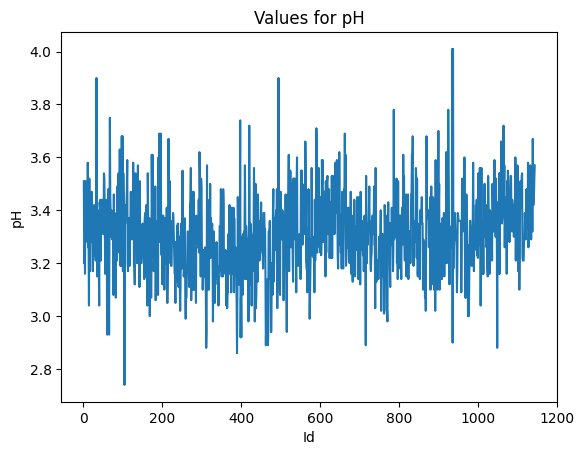

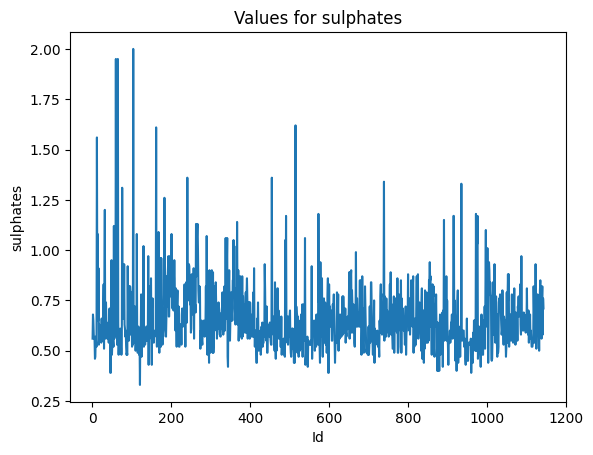

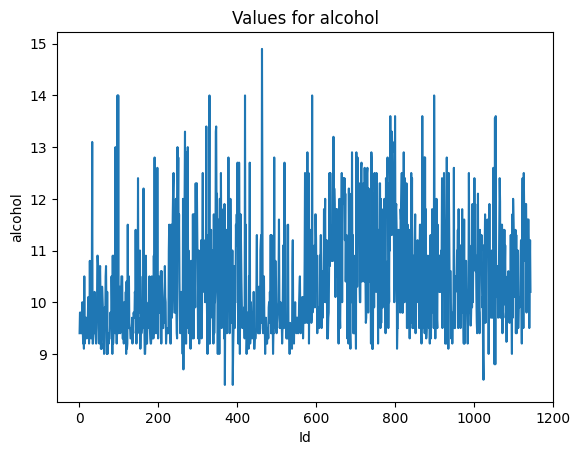

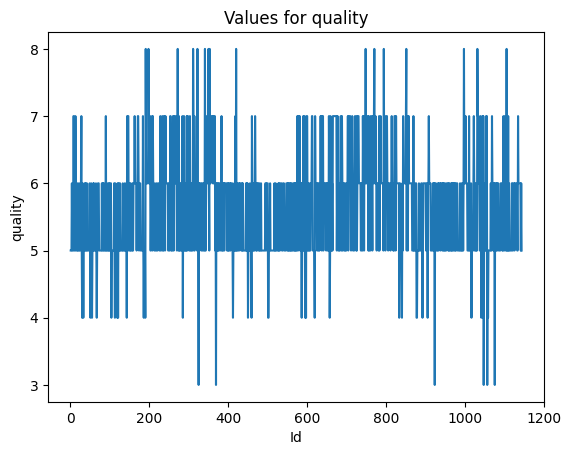

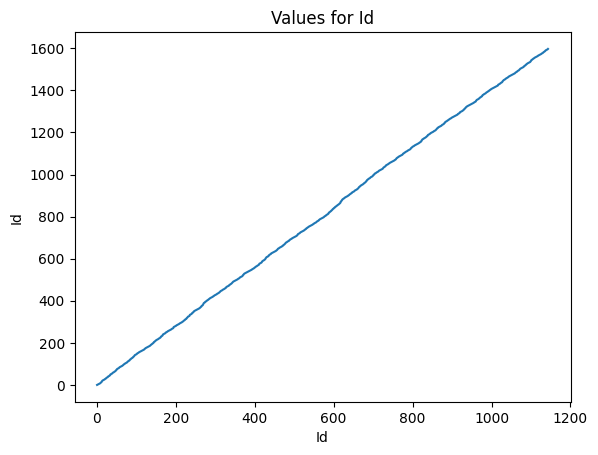

In [24]:
for column_name in df.columns:
    plt.plot(X_plot, df[column_name].values)
    plt.xlabel("Id")
    plt.ylabel(column_name)
    plt.title("Values for {}".format(column_name))
    plt.show()

#### 3. Partition the dataset into train, validation, and test sets

In [25]:
X = df.drop(columns=['Id', 'quality'], axis='columns')
y = df['quality']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42)

#### 4. Normalise and standarize the data.

Normalization: Scales the data to a range of [0, 1].

In [26]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

# Fitting and transforming training data
X_train_normalized = scaler.fit_transform(X_train)

# Transforming validation and test data 
X_val_normalized = scaler.transform(X_val)
X_test_normalized = scaler.transform(X_test)


Standardization: transforms the data to have a mean of 0 and a standard deviation of 1.

In [27]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

# Fitting and transforming training data
X_train_standardized = scaler.fit_transform(X_train_normalized)

# Transforming validation and test data
X_val_standardized = scaler.transform(X_val_normalized)
X_test_standardized = scaler.transform(X_test_normalized)



## 1.2 Model Building from Scratch

#### 1. Create a Multinomial Logistic Regression model from scratch and Use cross entropy loss as loss function and Gradient descent as the optimization algorithm.

#### 2. Train the model, use sklearn classification report and print metrics on the validation set while training. Also, report loss and accuracy on train set.

In [28]:
project_name = 'question-1'
group_name = 'mlr'
experiment_name = 'lr'
wandb.init(
    project=project_name,
    group=group_name,
    name=experiment_name,
    config={
        "optimizer": "gd",
        "loss": "crossentropy",  # sparse_categorical_
        "metric": "accuracy",
        "epoch": 1000
    })
config = wandb.config

In [29]:

from sklearn.metrics import classification_report

class MultinomialLogisticRegression:
    def __init__(self, num_classes, learning_rate=0.01, num_epochs=1000):
        self.num_classes = num_classes
        self.learning_rate = learning_rate
        self.num_epochs = num_epochs

    def softmax(self, x):
        exp_x = np.exp(x - np.max(x, axis=1, keepdims=True))
        return exp_x / np.sum(exp_x, axis=1, keepdims=True)

    def one_hot_encode(self, y):
        num_samples = y.shape[0]
        one_hot = np.zeros((num_samples, self.num_classes))
        one_hot[np.arange(num_samples), y] = 1
        return one_hot

    def initialize_parameters(self, num_features):
        self.weights = np.random.rand(num_features, self.num_classes)  # random.rand
        self.biases = np.random.rand(self.num_classes)

    def gradient_descent(self, X, y, y_pred):
        num_samples = X.shape[0]
        dw = (1 / num_samples) * np.dot(X.T, (y_pred - self.one_hot_encode(y)))
        db = (1 / num_samples) * np.sum(y_pred - self.one_hot_encode(y), axis=0)
        self.weights -= self.learning_rate * dw
        self.biases -= self.learning_rate * db

    def fit(self, X, y, X_val, y_val):
        num_samples, num_features = X.shape
        self.initialize_parameters(num_features)

        for epoch in range(self.num_epochs):
            # Loss and accuracy on the training set
            scores = np.dot(X, self.weights) + self.biases
            probabilities = self.softmax(scores)
            loss = -np.mean(np.sum(self.one_hot_encode(y) * np.log(probabilities), axis=1))
            y_pred = np.argmax(probabilities, axis=1)
            accuracy = np.mean(y_pred == y)
            print(f"Epoch {epoch}/{self.num_epochs}, Training Loss: {loss:.4f}, Training Accuracy: {accuracy:.4f}")

            wandb.log({"train loss":loss})
            wandb.log({"train accuracy":accuracy})
            
            # Classification report on the validation set
            val_scores = np.dot(X_val, self.weights) + self.biases
            val_probabilities = self.softmax(val_scores)
            val_loss = -np.mean(np.sum(self.one_hot_encode(y_val) * np.log(val_probabilities), axis=1))
            val_y_pred = np.argmax(val_probabilities, axis=1)
            val_accuracy = np.mean(val_y_pred == y_val)
            print(f"Validation Accuracy: {val_accuracy:.4f}")
            print(classification_report(y_val, val_y_pred, zero_division=True))
            # print(classification_report(y_val, val_y_pred, labels=np.unique(y_pred)))
            
            wandb.log({"val loss":val_loss})
            wandb.log({"val accuracy":val_accuracy})
            
            # Gradient descent
            self.gradient_descent(X, y, probabilities)

model = MultinomialLogisticRegression(num_classes=9, learning_rate=0.1, num_epochs=1000)
model.fit(X_train_standardized, y_train, X_val_standardized, y_val)


Epoch 0/1000, Training Loss: 2.3351, Training Accuracy: 0.1985
Validation Accuracy: 0.2314
              precision    recall  f1-score   support

           0       0.00      1.00      0.00         0
           1       0.00      1.00      0.00         0
           2       0.00      1.00      0.00         0
           3       0.00      0.00      1.00         2
           4       0.17      0.33      0.22         6
           5       0.76      0.15      0.25        88
           6       0.46      0.26      0.33        94
           7       0.32      0.42      0.36        33
           8       0.00      0.00      1.00         6

    accuracy                           0.23       229
   macro avg       0.19      0.46      0.35       229
weighted avg       0.53      0.23      0.32       229

Epoch 1/1000, Training Loss: 2.2925, Training Accuracy: 0.2175
Validation Accuracy: 0.2489
              precision    recall  f1-score   support

           0       0.00      1.00      0.00         0
    

## 1.3 Hyperparameter Tuning and Evaluation

#### 1. Use your validation set and W&B logging to fine-tune the hyperparameters ( learning rate , epochs) for optimal results.

In [30]:
project_name = 'question-1'
group_name = 'mlr'
experiment_name = 'lr'
wandb.init(
    project=project_name,
    group=group_name,
    name=experiment_name,
    config={
        "optimizer": "gd",
        "loss": "crossentropy",  # sparse_categorical_
        "metric": "accuracy",
        "epoch": 1000,
    })
config = wandb.config

train accuracy,▁▆▇▇▇███████████████████████████████████
train loss,█▅▃▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val accuracy,▁▆▇▇▇▇▇█████████████████████████████████
val loss,█▄▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train accuracy,0.61752
train loss,0.92992
val accuracy,0.59825
val loss,0.99902


#### 2. Evaluate your model on test dataset and print sklearn classification report.

In [31]:
# Loss and accuracy on the test set
scores = np.dot(X_test_standardized, model.weights) + model.biases
probabilities = model.softmax(scores)
loss = -np.mean(np.sum(model.one_hot_encode(y_test) * np.log(probabilities), axis=1))
y_pred_test = np.argmax(probabilities, axis=1)
accuracy = np.mean(y_pred_test == y_test)
print(f"Test Loss: {loss:.4f}, Test Accuracy: {accuracy:.4f}")
print(classification_report(y_test, y_pred_test, zero_division=True))

Test Loss: 0.9238, Test Accuracy: 0.6332
              precision    recall  f1-score   support

           4       1.00      0.00      0.00         6
           5       0.67      0.73      0.70        96
           6       0.61      0.67      0.63        99
           7       0.56      0.35      0.43        26
           8       1.00      0.00      0.00         2

    accuracy                           0.63       229
   macro avg       0.77      0.35      0.35       229
weighted avg       0.64      0.63      0.62       229



# 2. Multi Layer Perceptron Classification

In [2]:
wine_data = pd.read_csv('WineQT.csv')
wine_data["bias"] = 0
wine_data_trans = wine_data.transpose()

df2 = wine_data.drop(columns=['quality','Id'])

quality_label = wine_data_trans.iloc[11]
quality_label_list = quality_label.tolist()
quality_label_list_int = [int(x) for x in quality_label_list]


X_train, X_temp, y_train, y_temp = train_test_split(df2, quality_label_list_int, test_size=0.2, random_state=42)

X_valid, X_test, y_valid, y_test = train_test_split(X_train, y_train, test_size=0.5, random_state=42)

## 2.1 Model Building from Scratch

In [6]:
project_name = 'question-2'
group_name = 'mlp'
experiment_name = 'classification'
wandb.init(
    project=project_name,
    group=group_name,
    name=experiment_name,
    config={
        "optimizer": "gd",
        "loss": "crossentropy",  # sparse_categorical_
        "metric": "accuracy",
        "epoch": 1000
    })
config = wandb.config

wandb: Currently logged in as: pronoy-patra. Use `wandb login --relogin` to force relogin


In [5]:

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def derivative_sigmoid(Z):
    sig_Z = sigmoid(Z)
    return sig_Z * (1 - sig_Z)

def relu(x):
    return np.maximum(0, x)

def relu_derivative(x):
    return np.where(x > 0, 1, 0)

def tanh(x):
    return np.tanh(x)

def tanh_derivative(x):
    return 1 - np.tanh(x) ** 2

def sgd_update(model, learning_rate):
    for _ in range(model.input_size):
        for i in range(len(model.inputs)):
            input_example = model.inputs[i:i+1]
            target_example = model.target[i:i+1]
            predicted = model.forward(input_example)
            model.backward(predicted, target_example)
            
def batch_update(model, learning_rate):
    # Batch Gradient Descent
    predicted = model.forward(model.inputs)
    model.backward(predicted, model.target)

def mini_batch_update(model, learning_rate, batch_size):
    for i in range(0, len(model.inputs), batch_size):
        input_batch = model.inputs[i:i+batch_size]
        target_batch = model.target[i:i+batch_size]
        predicted = model.forward(input_batch)
        model.backward(predicted, target_batch)
        
class MLPClassifier:
    def __init__(self, learning_rate=0.00001, activation='sig', optimizer='sgd'):
        self.learning_rate = learning_rate
        self.activation = activation
        self.optimizer = optimizer
        
        #define Hyperparameter 
        self.inputLayerSize = 12
        self.outputLayerSize = 6
        self.hiddenLayerSize = 15
        self.no_of_hiddenLayer = 2
              
        #Weights (Parameter)
        self.Weights = []
        self.bias = []
        
        leftSize = self.inputLayerSize
        rightSize = self.hiddenLayerSize
        if self.no_of_hiddenLayer == 0:
            rightSize = self.outputLayerSize
            
        for i in range(self.no_of_hiddenLayer+1):
            W = np.random.randn(leftSize, rightSize)
            self.Weights.append(W)
            b = np.zeros(rightSize)
            self.bias.append(b)
            leftSize = rightSize
            rightSize = self.hiddenLayerSize
            if i == self.no_of_hiddenLayer-1 :
                rightSize = self.outputLayerSize
                
    def _softMax(self, Z): 
        Z_adjusted = Z - np.max(Z, axis=1, keepdims=True)
        e_Z = np.exp(Z_adjusted)
        return e_Z / e_Z.sum(axis=1, keepdims=True)

    
    def _derivative_sigmoid(self,Z):
        sig_Z = self._sigmoid(Z)
        return sig_Z * (1 - sig_Z)
    
    def _derivative_softmax(self,Z):
        e_Z = np.exp(Z - np.max(Z))
        soft = e_Z / e_Z.sum(axis=0)
        return soft * (1 - soft.sum(axis=0))    
    
    def _sigmoid(self, Z):
        return 1 / (1 + np.exp(-Z))

    def _relu(self, Z):
        return np.maximum(0, Z)
    
    def one_hot_encoding(self, y):
        adjusted_y = y - 3  # Subtract 3 to make the classes start from 0
        one_hot_y = np.zeros((len(y), self.outputLayerSize))
        for i in range(len(adjusted_y)):
            one_hot_y[i, adjusted_y[i]] = 1
        return one_hot_y
        
    def forward(self,X):
        self.Z = [None] * (self.hiddenLayerSize+1)
        self.A = [None] * (self.hiddenLayerSize+1)
        self.Z[0] = np.dot(X,self.Weights[0])
        self.A[0] = self._sigmoid(self.Z[0])

        for i in range(self.no_of_hiddenLayer):
            self.Z[i+1] = np.dot(self.A[i],self.Weights[i+1])
            if i == self.no_of_hiddenLayer-1:
                self.A[i+1] = self._softMax(self.Z[i+1])
            else:  
                self.A[i+1] = self._sigmoid(self.Z[i+1])
                
        finalOutput = self.A[self.no_of_hiddenLayer]
        self.yhat = finalOutput
        return finalOutput
        
    def back_propagation(self,X,y):
           
        delta = self.yhat-y  
        dJdW = np.dot(self.A[self.no_of_hiddenLayer-1].T,delta)
        
        self.Weights[self.no_of_hiddenLayer] -= self.learning_rate * dJdW
        
        for i in range(self.no_of_hiddenLayer-1,-1,-1):
            curr_delta = np.dot(delta,self.Weights[i+1].T) * self._derivative_sigmoid(self.Z[i])
            delta = curr_delta
            if i == 0 :
                curr_dJdW = np.dot(X.T,curr_delta)
            else :
                curr_dJdW = np.dot(self.A[i-1].T,curr_delta)
            
            self.Weights[i] -= self.learning_rate * curr_dJdW
    
    def fit(self, X, y, epochs=10000):
        y = self.one_hot_encoding(y) 
        for epoch in range(epochs):
            # Forward pass
            output = self.forward(X)
  
            # Backward pass
            self.back_propagation(X, y)

        # Print final loss
        final_output = self.forward(X)
        final_loss = np.mean(np.square(y - final_output))
        print(f'Final Loss: {final_loss}')


    def predict(self,X):
        return self.forward(X)
    

model = MLPClassifier()
model.fit(np.array(X_train),np.array(y_train))
pred = model.predict(np.array(X_temp))
predictions_adjusted = np.argmax(pred, axis=1) + 3 

accuracy = np.mean(predictions_adjusted == y_temp) * 100
print(f"Accuracy: {accuracy}%")

Final Loss: 0.10025092516067777
Accuracy: 55.895196506550214%


## 2.3 Evaluating Model

#### 1. Test and print the classification report on the test set.

In [12]:
pred = model.predict(np.array(X_test))
pred = np.argmax(pred, axis=1) + 3 
from sklearn.metrics import classification_report
accuracy = np.mean(predictions_adjusted == y_temp) * 100
print(f"Accuracy: {accuracy}%")
class_report = classification_report(y_test, pred, zero_division=0)
print(class_report)

Accuracy: 55.895196506550214%
              precision    recall  f1-score   support

           3       0.00      0.00      0.00         3
           4       0.00      0.00      0.00        12
           5       0.56      0.61      0.59       189
           6       0.44      0.62      0.51       177
           7       0.00      0.00      0.00        66
           8       0.00      0.00      0.00        10

    accuracy                           0.49       457
   macro avg       0.17      0.20      0.18       457
weighted avg       0.40      0.49      0.44       457



#### 2. Compare the results with the results of the logistic regression model.

For logistice regression model: <br>
Test Accuracy: 0.6332 <br>

For MLP: <br>
Test Accuracy: 0.5589

# 3. Multilayer Perceptron Regression

## 3.1 Data Preprocessing

#### 1. Describe the dataset using mean, standard deviation, min, and max values for all attributes

In [2]:
df = pd.read_csv('HousingData.csv')
df.describe()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
count,486.000000,486.000000,486.000000,486.000000,506.000000,506.000000,486.000000,506.000000,506.000000,506.000000,506.000000,506.000000,486.000000,506.000000
mean,3.611874,11.211934,11.083992,0.069959,0.554695,6.284634,68.518519,3.795043,9.549407,408.237154,18.455534,356.674032,12.715432,22.532806
std,8.720192,23.388876,6.835896,0.255340,0.115878,0.702617,27.999513,2.105710,8.707259,168.537116,2.164946,91.294864,7.155871,9.197104
min,0.006320,0.000000,0.460000,0.000000,0.385000,3.561000,2.900000,1.129600,1.000000,187.000000,12.600000,0.320000,1.730000,5.000000
25%,0.081900,0.000000,5.190000,0.000000,0.449000,5.885500,45.175000,2.100175,4.000000,279.000000,17.400000,375.377500,7.125000,17.025000
50%,0.253715,0.000000,9.690000,0.000000,0.538000,6.208500,76.800000,3.207450,5.000000,330.000000,19.050000,391.440000,11.430000,21.200000
75%,3.560263,12.500000,18.100000,0.000000,0.624000,6.623500,93.975000,5.188425,24.000000,666.000000,20.200000,396.225000,16.955000,25.000000
max,88.976200,100.000000,27.740000,1.000000,0.871000,8.780000,100.000000,12.126500,24.000000,711.000000,22.000000,396.900000,37.970000,50.000000


#### 2. Draw a graph that shows the distribution of the various labels across the entire dataset.

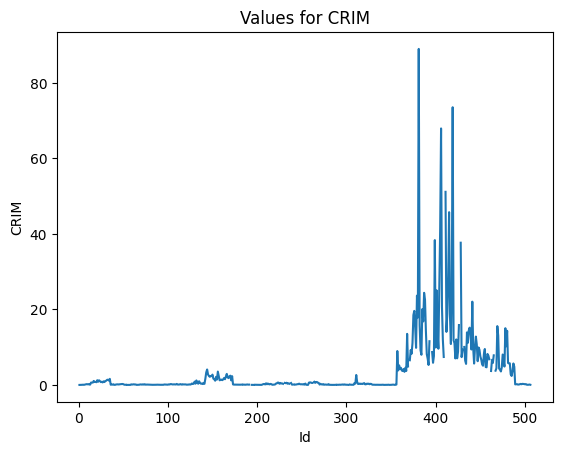

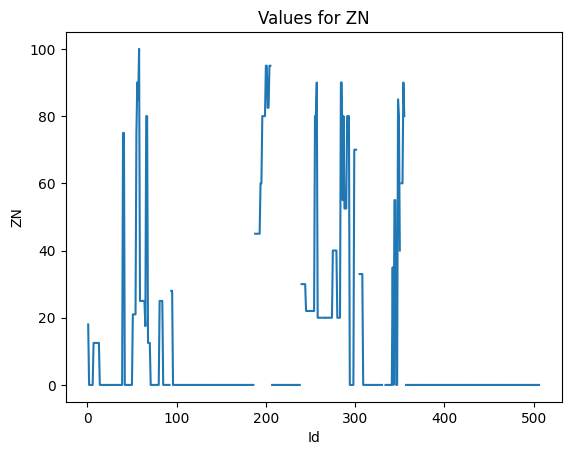

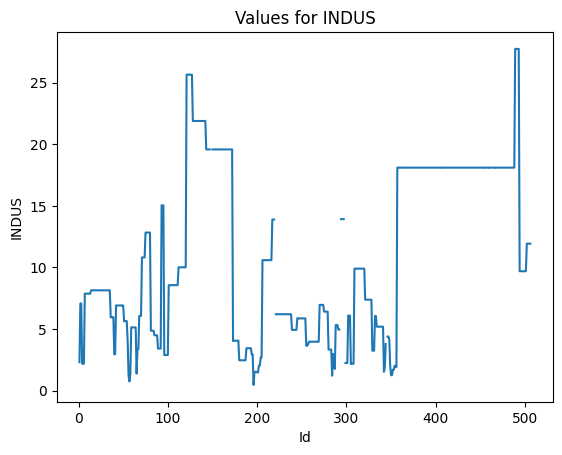

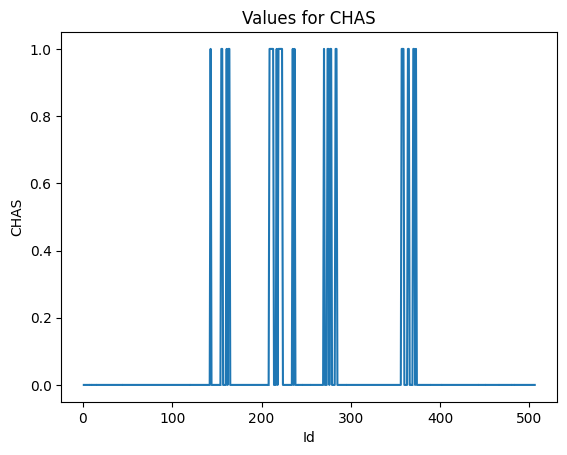

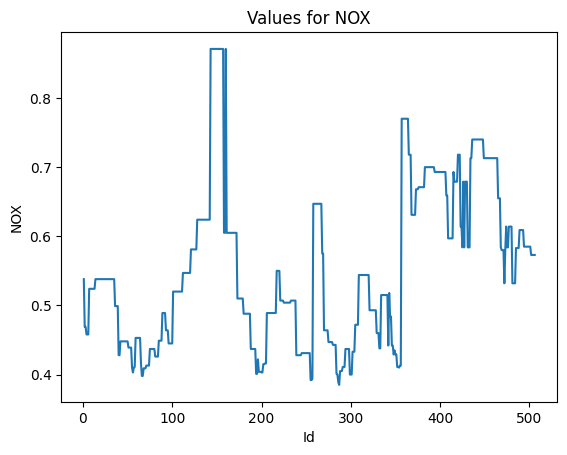

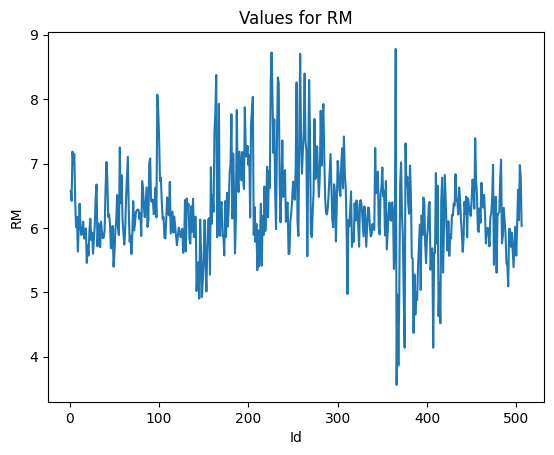

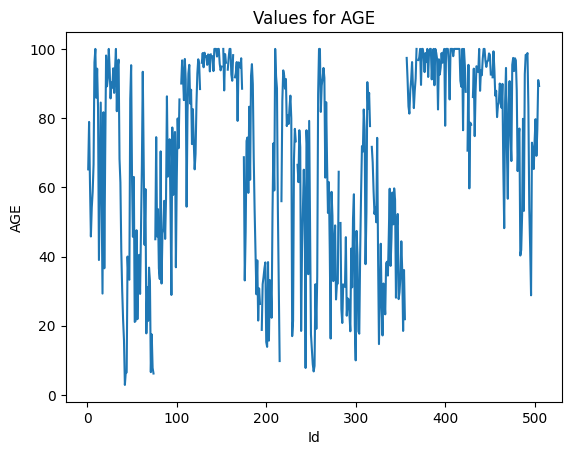

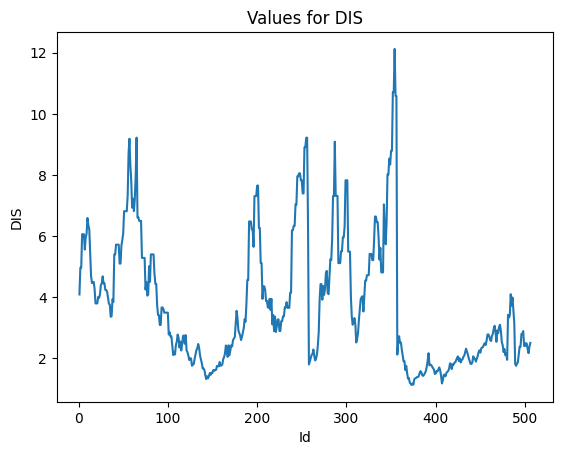

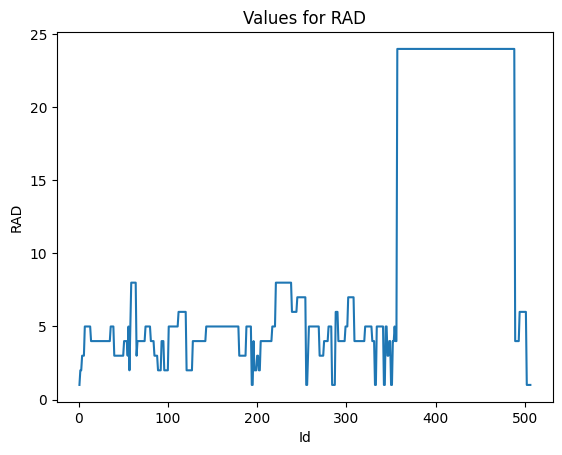

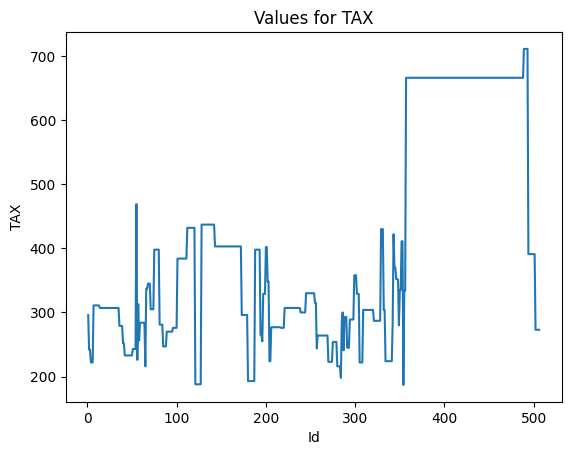

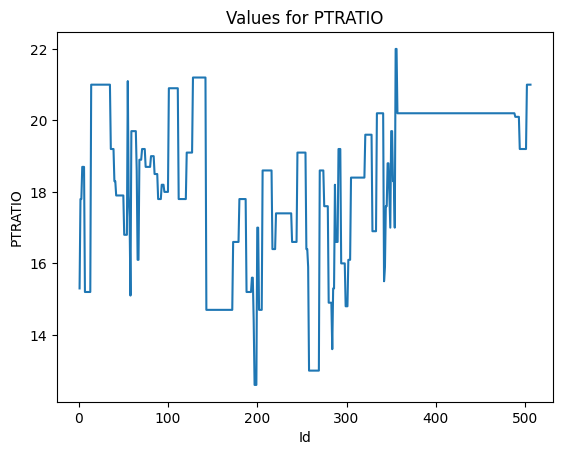

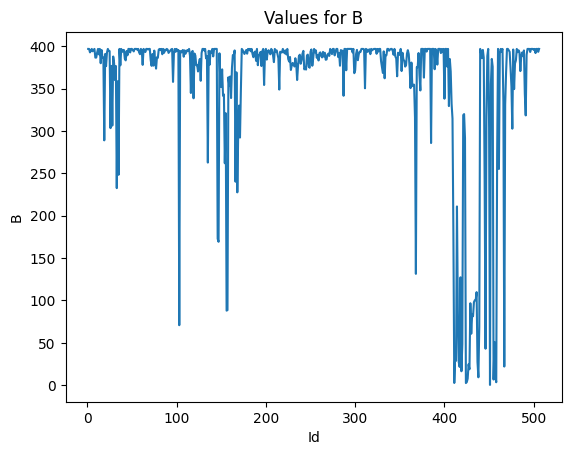

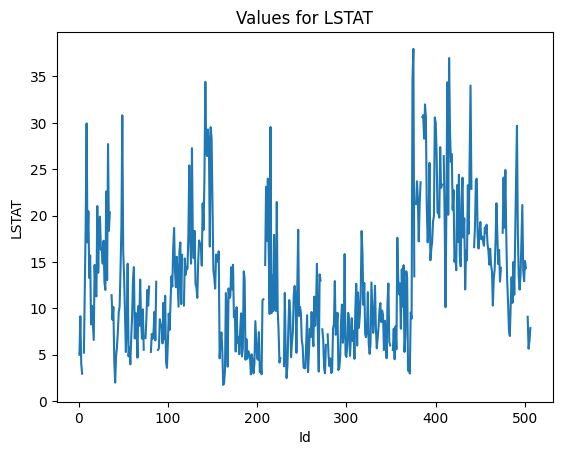

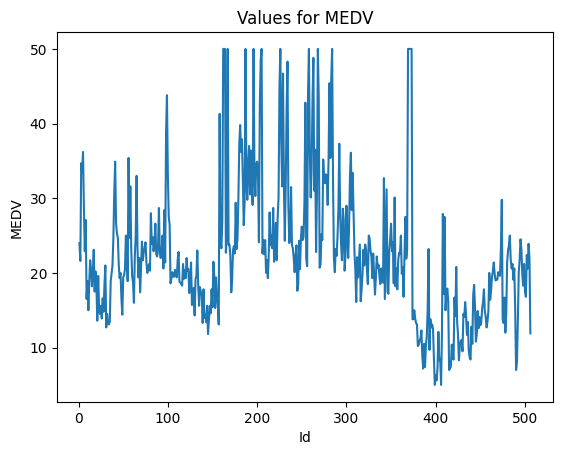

In [3]:
n = (df.shape[0])
X_plot = list(range(1, n + 1))

for column_name in df.columns:
    plt.plot(X_plot, df[column_name].values)
    plt.xlabel("Id")
    plt.ylabel(column_name)
    plt.title("Values for {}".format(column_name))
    plt.show()

#### 3. Partition the dataset into train, validation, and test sets.

In [4]:
X = df.drop('MEDV', axis=1)
y = df['MEDV']

imputer = SimpleImputer(strategy='mean')
X_imputed = imputer.fit_transform(X)
y_imputed = imputer.fit_transform(y.values.reshape(-1, 1))

X = pd.DataFrame(X_imputed, columns=X.columns)
y = pd.Series(y_imputed.flatten())

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size = 0.3, random_state = 42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size = 0.5, random_state = 42)


#### 4. Normalise and standarize the data. Make sure to handle the missing or inconsistent data values if necessary

In [5]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

# Fitting and transforming training data
X_train_normalized = scaler.fit_transform(X_train)

# Transforming validation and test data 
X_val_normalized = scaler.transform(X_val)
X_test_normalized = scaler.transform(X_test)


In [6]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

# Fitting and transforming training data
X_train_standardized = scaler.fit_transform(X_train_normalized)

# Transforming validation and test data
X_val_standardized = scaler.transform(X_val_normalized)
X_test_standardized = scaler.transform(X_test_normalized)

X_train = X_train_standardized
X_val = X_val_standardized
X_test = X_test_standardized

## 3.2 MLP Regression Implementation from Scratch

In [ ]:
project_name = 'question-3'
group_name = 'mlp'
experiment_name = 'regression'
wandb.init(
    project=project_name,
    group=group_name,
    name=experiment_name,
    config={
        "optimizer": "gd",
        "loss": "crossentropy", 
        "metric": "accuracy",
        "epoch": 1000
    })
config = wandb.config

In [18]:
# ChatGPT generated

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def derivative_sigmoid(Z):
    sig_Z = sigmoid(Z)
    return sig_Z * (1 - sig_Z)

def relu(x):
    return np.maximum(0, x)

def relu_derivative(x):
    return np.where(x > 0, 1, 0)

def tanh(x):
    return np.tanh(x)

def tanh_derivative(x):
    return 1 - np.tanh(x) ** 2

def sgd_update(model, learning_rate):
    for _ in range(model.input_size):
        for i in range(len(model.inputs)):
            input_example = model.inputs[i:i+1]
            target_example = model.target[i:i+1]
            predicted = model.forward(input_example)
            model.backward(predicted, target_example)
            
def batch_update(model, learning_rate):
    # Batch Gradient Descent
    predicted = model.forward(model.inputs)
    model.backward(predicted, model.target)

def mini_batch_update(model, learning_rate, batch_size):
    for i in range(0, len(model.inputs), batch_size):
        input_batch = model.inputs[i:i+batch_size]
        target_batch = model.target[i:i+batch_size]
        predicted = model.forward(input_batch)
        model.backward(predicted, target_batch)

class MLPRegressor:
    def __init__(self, input_size, hidden_layers, neurons_per_layer, output_size, learning_rate=0.01):
        self.input_size = input_size
        self.hidden_layers = hidden_layers
        self.neurons_per_layer = neurons_per_layer
        self.output_size = output_size
        self.learning_rate = learning_rate
        
        self.weights = []
        self.biases = []
        
        # Activation functions
        self.activations = [relu] * (hidden_layers + 1)
        self.activation_derivatives = [relu_derivative] * (hidden_layers + 1)
        
        for i in range(hidden_layers + 1):
            if i == 0:
                self.weights.append(np.random.randn(input_size, neurons_per_layer[i]))
                self.biases.append(np.zeros((1, neurons_per_layer[i])))
            elif i == hidden_layers:
                self.weights.append(np.random.randn(neurons_per_layer[i - 1], output_size))
                self.biases.append(np.zeros((1, output_size)))
            else:
                self.weights.append(np.random.randn(neurons_per_layer[i - 1], neurons_per_layer[i]))
                self.biases.append(np.zeros((1, neurons_per_layer[i])))
        
    def set_activation(self, layer, activation_function):
        self.activations[layer] = activation_function
        if activation_function == sigmoid:
            self.activation_derivatives[layer] = derivative_sigmoid
        elif activation_function == relu:
            self.activation_derivatives[layer] = relu_derivative
    
    def forward(self, x):
        self.layer_outputs = [x]
        
        for i in range(len(self.weights)):
            x = np.dot(x, self.weights[i]) + self.biases[i]
            x = self.activations[i](x)
            self.layer_outputs.append(x)
        
        return x
    
    def backward(self, x, y, output):
        errors = [y - output]
        deltas = [errors[0] * self.activation_derivatives[-1](output)]
        
        # Backpropagation
        for i in range(self.hidden_layers, 0, -1):
            error = deltas[-1].dot(self.weights[i].T)
            delta = error * self.activation_derivatives[i - 1](self.layer_outputs[i])
            errors.append(error)
            deltas.append(delta)
        
        errors.reverse()
        deltas.reverse()
        
        # Update weights and biases
        for i in range(len(self.weights)):
            if i == 0:
                self.weights[i] += np.atleast_2d(self.layer_outputs[i]).T.dot(np.atleast_2d(deltas[i])) * self.learning_rate
            else:
                self.weights[i] += np.atleast_2d(self.layer_outputs[i]).T.dot(deltas[i]) * self.learning_rate
            self.biases[i] += np.sum(deltas[i], axis=0, keepdims=True) * self.learning_rate
        
    def train(self, X, y, epochs):
        for epoch in range(epochs):
            for i in range(len(X)):
                x = X[i]
                y_true = y[i]
                output = self.forward(x)
                self.backward(x, y_true, output)
    
    def predict(self, X):
        predictions = []
        for x in X:
            output = self.forward(x) 
            predictions.append(output)
        return np.array(predictions)


# Sample Run
y_train = np.asarray(y_train).reshape(-1, 1)

mlp = MLPRegressor(input_size = X_train.shape[1], hidden_layers=2, neurons_per_layer=[64, 32], output_size=1, learning_rate=0.01)

mlp.train(X_train, y_train, epochs=1000)


predictions = mlp.predict(X_val)

y_val = np.asarray(y_val).reshape(-1, 1)

mse = ((y_val - predictions) ** 2).mean()
print("Mean Squared Error on Validation Set:", mse)

# Test the model on the test set
test_predictions = mlp.predict(X_test)

Mean Squared Error on Validation Set: 540.4884210526316


In [60]:
# ChatGPT generated

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def sigmoid_derivative(Z):
    sig_Z = sigmoid(Z)
    return sig_Z * (1 - sig_Z)

def relu(x):
    return np.maximum(0, x)

def relu_derivative(x):
    return np.where(x > 0, 1, 0)

def tanh(x):
    return np.tanh(x)

def tanh_derivative(x):
    return 1 - np.tanh(x) ** 2

def sgd_update(model, X, y, learning_rate, epochs):
    for epoch in range(epochs):
        for i in range(len(X)):
            x = X[i]
            y_true = y[i]
            output = model.forward(x)
            model.backward(x, y_true, output)
            
def batch_update(model, X, y, learning_rate, epochs):
    for epoch in range(epochs):
        outputs = []
        for i in range(len(X)):
            x = X[i]
            y_true = y[i]
            output = model.forward(x)
            outputs.append(output)
            # model.backward(x, y_true, output)
        
        for i in range(len(X)):
            # x = X[i]
            # y_true = y[i]
            #output = model.forward(x)
            output = outputs[i]
            model.backward(x, y_true, output)

def mini_batch_update(model, X, y, learning_rate, epochs, batch_size):
    for i in range(0, len(X), batch_size):
        outputs=[]
        for j in range (i, i+batch_size):
            if j>=len(X):
                break
            x = X[j]
            y_true = y[j]
            output = model.forward(x)
            outputs.append(output)
            # model.backward(x, y_true, output)
        itr=0
        for j in range (i, i+batch_size):
            if j>=len(X):
                break
            # x = X[j]
            # y_true = y[j]
            # output = model.forward(x)
            output = outputs[itr]
            itr=itr+1
            model.backward(x, y_true, output)

class MLPRegressor:
    def __init__(self, input_size, hidden_layers, neurons_per_layer, output_size, optimizer, activation_fn, learning_rate=0.01):
        self.input_size = input_size
        self.hidden_layers = hidden_layers
        self.neurons_per_layer = neurons_per_layer
        self.output_size = output_size
        self.learning_rate = learning_rate
        self.optimizer = optimizer
        
        # Weights and biases
        self.weights = []
        self.biases = []
        self.activation_fn = activation_fn
        
        # Activation functions
        if(self.activation_fn=="relu"):
            act = relu
            act_derivative = relu_derivative

        if(self.activation_fn=="sigmoid"):
            act = sigmoid
            act_derivative = sigmoid_derivative

        if(self.activation_fn=="tanh"):
            act = tanh
            act_derivative = tanh_derivative
            
        self.activations = [act] * (hidden_layers + 1)
        self.activation_derivatives = [act_derivative] * (hidden_layers + 1)
        
        for i in range(hidden_layers + 1):
            if i == 0:
                self.weights.append(np.random.randn(input_size, neurons_per_layer[i]))
                self.biases.append(np.zeros((1, neurons_per_layer[i])))
            elif i == hidden_layers:
                self.weights.append(np.random.randn(neurons_per_layer[i - 1], output_size))
                self.biases.append(np.zeros((1, output_size)))
            else:
                self.weights.append(np.random.randn(neurons_per_layer[i - 1], neurons_per_layer[i]))
                self.biases.append(np.zeros((1, neurons_per_layer[i])))
        
    def set_activation(self, layer, activation_function):
        self.activations[layer] = activation_function
        if activation_function == sigmoid:
            self.activation_derivatives[layer] = derivative_sigmoid
        elif activation_function == act:
            self.activation_derivatives[layer] = act_derivative
    
    def forward(self, x):
        self.layer_outputs = [x]
        
        for i in range(len(self.weights)):
            x = np.dot(x, self.weights[i]) + self.biases[i]
            x = self.activations[i](x)
            self.layer_outputs.append(x)
        
        return x
    
    def backward(self, x, y, output):
        errors = [y - output]
        deltas = [errors[0] * self.activation_derivatives[-1](output)]
        
        # Backpropagation
        for i in range(self.hidden_layers, 0, -1):
            error = deltas[-1].dot(self.weights[i].T)
            delta = error * self.activation_derivatives[i - 1](self.layer_outputs[i])
            errors.append(error)
            deltas.append(delta)
        
        errors.reverse()
        deltas.reverse()
        
        # Update weights and biases
        for i in range(len(self.weights)):
            if i == 0:
                self.weights[i] += np.atleast_2d(self.layer_outputs[i]).T.dot(np.atleast_2d(deltas[i])) * self.learning_rate
            else:
                self.weights[i] += np.atleast_2d(self.layer_outputs[i]).T.dot(deltas[i]) * self.learning_rate
            self.biases[i] += np.sum(deltas[i], axis=0, keepdims=True) * self.learning_rate
        
    def train(self, X, y, epochs):
        if self.optimizer == "sgd":
            sgd_update(self, X, y, self.learning_rate, epochs)

        if self.optimizer == "batch":
            batch_update(self, X, y, self.learning_rate, epochs)

        if self.optimizer == "minibatch":
            mini_batch_size = 50
            mini_batch_update(self, X, y, self.learning_rate, epochs, mini_batch_size)   
    
    def predict(self, X):
        predictions = []
        for x in X:
            output = self.forward(x) 
            predictions.append(output)
        return np.array(predictions)


# Sample Run
y_train = np.asarray(y_train).reshape(-1, 1)

mlp = MLPRegressor(input_size = X_train.shape[1], hidden_layers=2, neurons_per_layer=[64, 32], output_size=1, optimizer="sgd", activation_fn="relu", learning_rate=0.01)

mlp.train(X_train, y_train, epochs=1000)

y_pred = mlp.predict(X_val)
y_pred = np.asarray(y_pred).reshape(-1, 1)
y_true = np.asarray(y_val).reshape(-1, 1)

from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

mse = mean_squared_error(y_true, y_pred)
print(f"Mean Squared Error (MSE): {mse:.4f}")

r_squared = r2_score(y_true, y_pred)
print(f"R-squared: {r_squared:.4f}")

rmse = np.sqrt(mse)
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")


Mean Squared Error (MSE): 540.4884
R-squared: -6.7914
Root Mean Squared Error (RMSE): 23.2484


## 3.3 Model Training & Hyperparameter Tuning using W&B

In [65]:
project_name = 'question-3'
group_name = 'mlp'
experiment_name = 'regression'
wandb.init(
    project=project_name,
    group=group_name,
    name=experiment_name,
    config={
        "optimizer": "gd",
        "loss": "crossentropy", 
        "metric": "accuracy",
        "epoch": 1000
    })
config = wandb.config

wandb: Currently logged in as: pronoy-patra. Use `wandb login --relogin` to force relogin


In [66]:
optimizers = ["sgd", "batch", "minibatch"]
activations = ["relu", "sigmoid", "tanh"]

for opt in optimizers:
    for act in activations:
        y_train = np.asarray(y_train).reshape(-1, 1)
        mlp = MLPRegressor(input_size = X_train.shape[1], hidden_layers=2, neurons_per_layer=[64, 32], output_size=1, optimizer=opt, activation_fn=act, learning_rate=0.01)
        mlp.train(X_train, y_train, epochs=1000)
        
        y_pred = mlp.predict(X_val)
        y_pred = np.asarray(y_pred).reshape(-1, 1)
        y_true = np.asarray(y_val).reshape(-1, 1)
        
        from sklearn.metrics import r2_score
        from sklearn.metrics import mean_squared_error
        
        mse = mean_squared_error(y_true, y_pred)
        print(f"Mean Squared Error (MSE): {mse:.4f}")
        
        r_squared = r2_score(y_true, y_pred)
        print(f"R-squared: {r_squared:.4f}")
        
        rmse = np.sqrt(mse)
        print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")

        wandb.log({"MSE loss":mse})
        wandb.log({"R-squared loss":r_squared})
        wandb.log({"RMSE loss":rmse})


Mean Squared Error (MSE): 540.4884
R-squared: -6.7914
Root Mean Squared Error (RMSE): 23.2484


C:\Users\BPATR\AppData\Local\Temp\ipykernel_5944\3133866749.py:4: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-x))


Mean Squared Error (MSE): 498.0779
R-squared: -6.1800
Root Mean Squared Error (RMSE): 22.3177
Mean Squared Error (MSE): 511.4674
R-squared: -6.3730
Root Mean Squared Error (RMSE): 22.6156
Mean Squared Error (MSE): 540.4884
R-squared: -6.7914
Root Mean Squared Error (RMSE): 23.2484


C:\Users\BPATR\AppData\Local\Temp\ipykernel_5944\3133866749.py:4: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-x))


Mean Squared Error (MSE): 498.0779
R-squared: -6.1800
Root Mean Squared Error (RMSE): 22.3177
Mean Squared Error (MSE): 534.7411
R-squared: -6.7085
Root Mean Squared Error (RMSE): 23.1245
Mean Squared Error (MSE): 540.4884
R-squared: -6.7914
Root Mean Squared Error (RMSE): 23.2484
Mean Squared Error (MSE): 498.0779
R-squared: -6.1800
Root Mean Squared Error (RMSE): 22.3177
Mean Squared Error (MSE): 519.0200
R-squared: -6.4819
Root Mean Squared Error (RMSE): 22.7820


C:\Users\BPATR\AppData\Local\Temp\ipykernel_5944\3133866749.py:4: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-x))


## 3.4 Evaluating Model

In [62]:
y_pred = mlp.predict(X_test)
y_pred = np.asarray(y_pred).reshape(-1, 1)
y_true = np.asarray(y_test).reshape(-1, 1)

from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

mse = mean_squared_error(y_true, y_pred)
print(f"Mean Squared Error (MSE): {mse:.4f}")

r_squared = r2_score(y_true, y_pred)
print(f"R-squared: {r_squared:.4f}")

rmse = np.sqrt(mse)
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")

Mean Squared Error (MSE): 525.1337
R-squared: -5.6072
Root Mean Squared Error (RMSE): 22.9158
